<a href="https://colab.research.google.com/github/zbransi/solar_moving_magnetic_features/blob/main/play_combo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install sunpy[map]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.2/195.2 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.9/378.9 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 4.1 MB/s eta 0:00:00


Height is 3.52, Width is 7.2.
2796 max: 281.3128945086038, min: 8.75799576116654
1400 max: 107.06155118863111, min: 0.0
1330 max: 51.92622245760281, min: 0.0


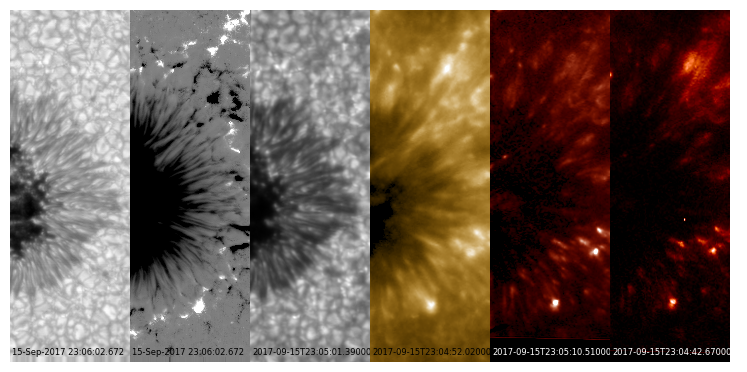

In [ ]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib.animation import FuncAnimation
import sunpy.visualization.colormaps as cm

types = ['cont', 'bz', '2832', '2796', '1400', '1330']
movs = {}

irissji2796 = matplotlib.colormaps['irissji2796']
irissji1400 = matplotlib.colormaps['irissji1400']
irissji1330 = matplotlib.colormaps['irissji1330']

def add_dat(t):
    hdul = fits.open(f"/content/drive/MyDrive/DATA_LM/coaligned_data/{t}.fits")
    images = []
    times = []

    for hdu in hdul:
        if hdu.data is not None:
            images.append(hdu.data)
            times.append(hdu.header['DATE_OBS'])

    hdul.close()

    if t not in movs:
        movs[t] = {
            'images' : images,
            'times' : times,
            'ax' : None,
            'im' : None,
            'text' : None,
            'flip' : None
        }

for t in types:
    add_dat(t)

dpi = 100
h, w = movs['cont']['images'][0].shape
w = len(types) * w / dpi
h = h / dpi
print(f"Height is {h}, Width is {w}.")
fig = plt.figure(figsize=(w, h), dpi=dpi)

for i, t in enumerate(types):
    ax = fig.add_axes([i/len(types), 0.0, 1/len(types), 1.0])
    ax.axis('off')
    movs[t]['ax'] = ax

    if (t == 'bz'):
        im = ax.imshow(movs[t]['images'][0], cmap='gray', interpolation=None, aspect='equal', vmin=-1000, vmax=+1000)
    elif (t == '1330'):
        current_max = np.max(movs[t]['images'][0])
        current_min = np.min(movs[t]['images'][0])
        print(f"1330 max: {current_max}, min: {current_min}")
        im = ax.imshow(movs[t]['images'][0], cmap=irissji1330, interpolation=None, aspect='equal', vmin=current_min + 1, vmax=current_max * 0.75)
    elif (t == '1400'):
        current_max = np.max(movs[t]['images'][0])
        current_min = np.min(movs[t]['images'][0])
        print(f"1400 max: {current_max}, min: {current_min}")
        im = ax.imshow(movs[t]['images'][0], cmap=irissji1400, interpolation=None, aspect='equal', vmin=current_min + 2, vmax=current_max * 0.7)
    elif (t == '2796'):
        current_max = np.max(movs[t]['images'][0])
        current_min = np.min(movs[t]['images'][0])
        print(f"2796 max: {current_max}, min: {current_min}")
        im = ax.imshow(movs[t]['images'][0], cmap=irissji2796, interpolation=None, aspect='equal', vmin=current_min + 10, vmax=current_max - 20)
    else:
        im = ax.imshow(movs[t]['images'][0], cmap='gray', interpolation=None, aspect='equal')

    if (t == '1400' or t == '1330'):
        text = ax.text(0.02, 0.02, '', transform=ax.transAxes, color='white', fontsize=6)
    else:
        text = ax.text(0.02, 0.02, '', transform=ax.transAxes, color='black', fontsize=6)

    movs[t]['im'] = im
    movs[t]['text'] = text

old_contours = []
show_contours = False

def update(frame):
    global old_contours
    global show_contours

    actors = []

    for c in old_contours:
        for coll in c.collections:
            coll.remove()
    old_contours.clear()

    for t in types:
        movs[t]['flip'] = np.flipud(movs[t]['images'][frame])
        movs[t]['im'].set_array(movs[t]['flip'])
        time = movs[t]['times'][frame]
        movs[t]['text'].set_text(time)

        actors.extend([movs[t]['im'], movs[t]['text']])

    if show_contours:
        def add_contour(from_map, level, colors):
            threshold = np.percentile(movs[from_map]['images'][frame], level)

            for t in types:
                contour = movs[t]['ax'].contour(movs[from_map]['flip'], levels=[threshold], colors=colors, linewidths=0.2)
                actors.extend(contour.collections)
                old_contours.append(contour)

        add_contour(from_map='cont', level=5, colors='white')

    return actors

plt.ion()

ani = FuncAnimation(fig, update, frames=len(movs['cont']['images']), interval=25)

ani.save('/content/drive/MyDrive/DATA_LM/movies/movie_no_contours.mp4', dpi=100, writer='ffmpeg', fps=12)